In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
counts_df = pd.read_csv('/home/jiguo/data/data/outdir_rnaseq/counts/filtered_annotated_counts.txt', sep='\t', index_col=0)
sample_info = pd.read_csv('/home/jiguo/data/data/outdir_rnaseq/counts/sample_metadata.csv', index_col=0)

In [ ]:
sample_info

,cell_line,condition,replicate
sample_id,,,
rep1_0,HeLa,with_centrioles,1
rep1_1,HeLa,with_centrioles,2
rep2_0,RPE-p53KO,with_centrioles,1
rep2_1,RPE-p53KO,with_centrioles,2
rep3_0,KE37-WT,with_centrioles,1
rep3_1,KE37-WT,with_centrioles,2
control,RPE-SAS6KO,without_centrioles,1


In [ ]:
counts_df

,control,rep3_1,rep2_1,rep1_1,rep1_0,rep3_0,rep2_0
Geneid,,,,,,,
ENSG00000290825.2,2,0,0,0,0,10,0
ENSG00000310526.1,33,287,14,64,79,927,29
ENSG00000243485.6,0,3,2,3,4,21,0
ENSG00000290826.2,0,1,2,5,0,0,0
ENSG00000268020.3,0,0,10,0,0,0,0
...,...,...,...,...,...,...,...
ENSG00000309296.1,0,9,0,21,28,0,0
ENSG00000303573.1,0,0,4,0,0,0,0
ENSG00000306528.1,0,1,0,20,38,0,0


In [5]:
library_sizes = counts_df.sum(axis=0)
cpm = counts_df.div(library_sizes, axis=1) * 1e6 # axis =1 for meaning column-wise division
log_cpm=np.log2(cpm + 1)  # log2 transform with pseudocount of 1
print("library sizes:\n", library_sizes)

library sizes:
 control    141404928
rep3_1     117089491
rep2_1     139336470
rep1_1     163383482
rep1_0     117562320
rep3_0      68407431
rep2_0     157378275
dtype: int64


In [6]:
sample_info

,cell_line,condition,replicate
sample_id,,,
rep1_0,HeLa,with_centrioles,1
rep1_1,HeLa,with_centrioles,2
rep2_0,RPE-p53KO,with_centrioles,1
rep2_1,RPE-p53KO,with_centrioles,2
rep3_0,KE37-WT,with_centrioles,1
rep3_1,KE37-WT,with_centrioles,2
control,RPE-SAS6KO,without_centrioles,1


## For RPE-1 cells variation between 2 replicates

In [7]:
replicate_1 = sample_info[
    (sample_info['replicate'] == 1) &
    (sample_info['cell_line'] == 'RPE-p53KO')
].index

replicate_2 = sample_info[
    (sample_info['replicate'] == 2) &
    (sample_info['cell_line'] == 'RPE-p53KO')
].index

# use CPM values
rep1_expr = log_cpm[replicate_1[0]]  # Get the single column as a Series
rep2_expr = log_cpm[replicate_2[0]]  # Get the single column as a Series

# calculate mean expression and fold change
fold_change = rep1_expr - rep2_expr
mean_expr = (rep1_expr + rep2_expr) / 2

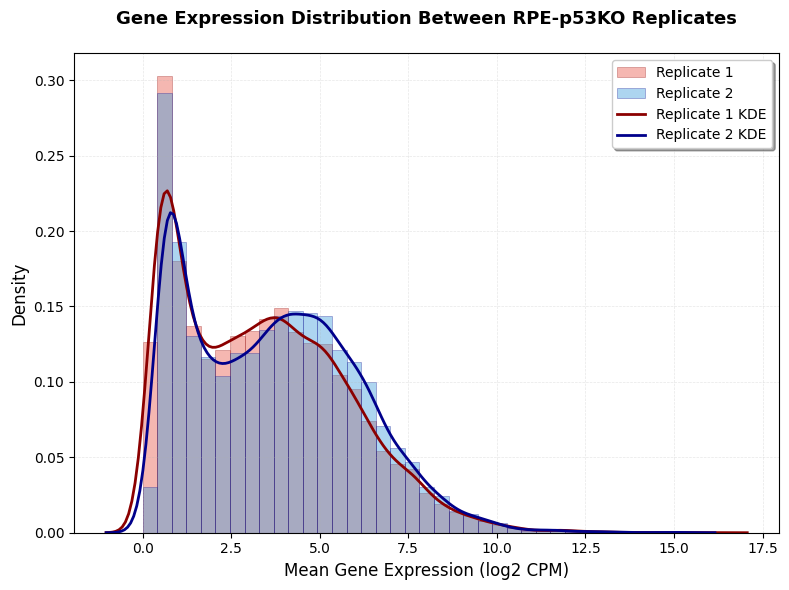

In [8]:
# Advanced histogram with KDE overlay
fig, ax = plt.subplots(figsize=(8, 6))

# Filter out very low expression for better visualization
expressed_mask = (rep1_expr > 0.5) | (rep2_expr > 0.5)
rep1_expressed = rep1_expr[expressed_mask]
rep2_expressed = rep2_expr[expressed_mask]

bins = np.linspace(0, max(rep1_expressed.max(), rep2_expressed.max()), 40)

# Histograms with density
ax.hist(rep1_expressed, bins=bins, alpha=0.4, label='Replicate 1',
        color='#E74C3C', edgecolor='darkred', linewidth=0.5, density=True)
ax.hist(rep2_expressed, bins=bins, alpha=0.4, label='Replicate 2',
        color='#3498DB', edgecolor='darkblue', linewidth=0.5, density=True)

# Add KDE overlay using seaborn
sns.kdeplot(data=rep1_expressed, color='darkred', linewidth=2, 
            label='Replicate 1 KDE', ax=ax)
sns.kdeplot(data=rep2_expressed, color='darkblue', linewidth=2,
            label='Replicate 2 KDE', ax=ax)

ax.set_xlabel('Mean Gene Expression (log2 CPM)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Gene Expression Distribution Between RPE-p53KO Replicates\n', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## difference between mean(RPE-rep_1, RPE-rep2) and control

In [9]:
centriole_sample = sample_info[
    (sample_info['cell_line'] == 'RPE-p53KO')
].index

control_sample = sample_info[
    (sample_info['condition'] == 'without_centrioles')
].index

# use CPM values
centriole_expr_mean = log_cpm[centriole_sample].mean(axis=1)
control_expr = log_cpm[control_sample[0]]  # Get the single column as a Series

# calculate mean expression and fold change
fold_change = centriole_expr_mean - control_expr
mean_expr = (centriole_expr_mean + control_expr) / 2

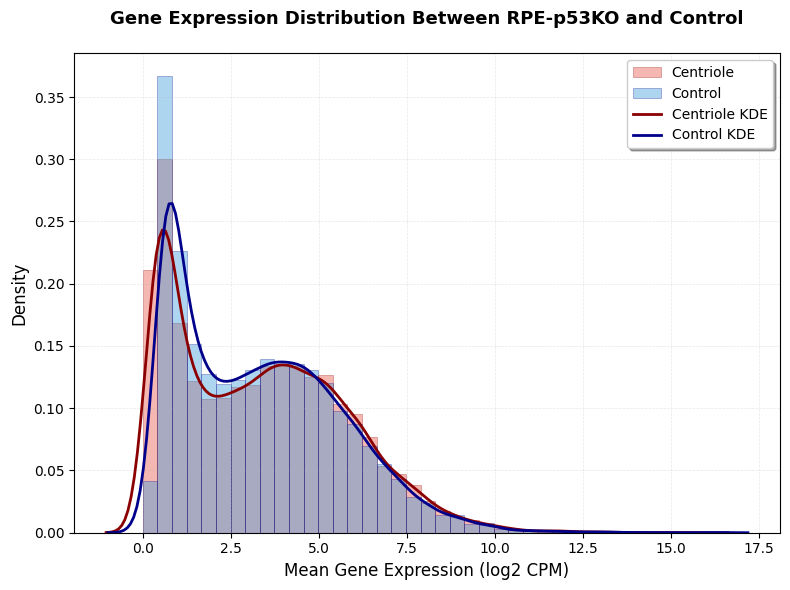

In [10]:
# Advanced histogram with KDE overlay
fig, ax = plt.subplots(figsize=(8, 6))

# Filter out very low expression for better visualization
expressed_mask = (centriole_expr_mean > 0.5) | (control_expr > 0.5)
centriole_expressed = centriole_expr_mean[expressed_mask]
control_expressed = control_expr[expressed_mask]

bins = np.linspace(0, max(centriole_expressed.max(), control_expressed.max()), 40)

# Histograms with density
ax.hist(centriole_expressed, bins=bins, alpha=0.4, label='Centriole',
        color='#E74C3C', edgecolor='darkred', linewidth=0.5, density=True)
ax.hist(control_expressed, bins=bins, alpha=0.4, label='Control',
        color='#3498DB', edgecolor='darkblue', linewidth=0.5, density=True)

# Add KDE overlay using seaborn
sns.kdeplot(data=centriole_expressed, color='darkred', linewidth=2, 
            label='Centriole KDE', ax=ax)
sns.kdeplot(data=control_expressed, color='darkblue', linewidth=2,
            label='Control KDE', ax=ax)

ax.set_xlabel('Mean Gene Expression (log2 CPM)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Gene Expression Distribution Between RPE-p53KO and Control\n', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Between HeLa replicates

In [11]:
replicate_1 = sample_info[
    (sample_info['replicate'] == 1) &
    (sample_info['cell_line'] == 'HeLa')
].index

replicate_2 = sample_info[
    (sample_info['replicate'] == 2) &
    (sample_info['cell_line'] == 'HeLa')
].index

# use CPM values
rep1_expr = log_cpm[replicate_1[0]]  # Get the single column as a Series
rep2_expr = log_cpm[replicate_2[0]]  # Get the single column as a Series

# calculate mean expression and fold change
fold_change = rep1_expr - rep2_expr
mean_expr = (rep1_expr + rep2_expr) / 2

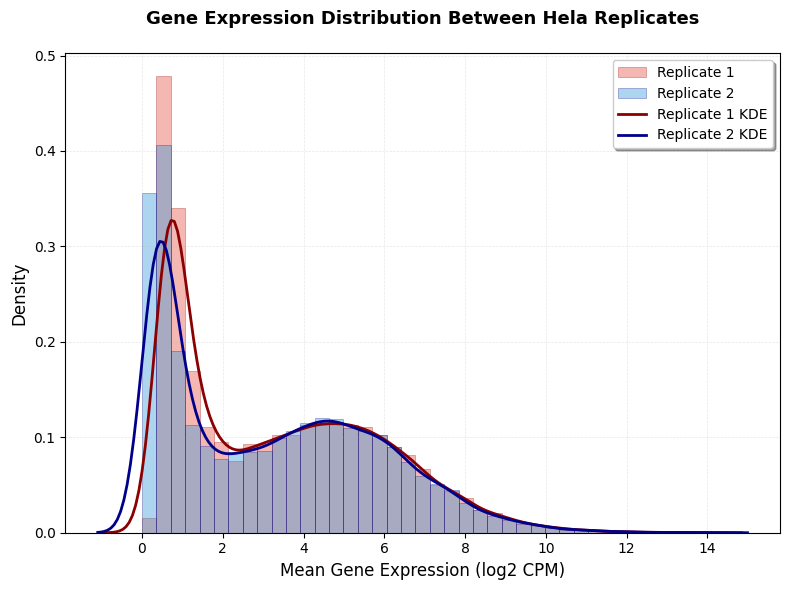

In [12]:
# Advanced histogram with KDE overlay
fig, ax = plt.subplots(figsize=(8, 6))

# Filter out very low expression for better visualization
expressed_mask = (rep1_expr > 0.5) | (rep2_expr > 0.5)
rep1_expressed = rep1_expr[expressed_mask]
rep2_expressed = rep2_expr[expressed_mask]

bins = np.linspace(0, max(rep1_expressed.max(), rep2_expressed.max()), 40) # define bins based on max expression

# Histograms with density
ax.hist(rep1_expressed, bins=bins, alpha=0.4, label='Replicate 1',
        color='#E74C3C', edgecolor='darkred', linewidth=0.5, density=True)
ax.hist(rep2_expressed, bins=bins, alpha=0.4, label='Replicate 2',
        color='#3498DB', edgecolor='darkblue', linewidth=0.5, density=True)

# Add KDE overlay using seaborn
sns.kdeplot(data=rep1_expressed, color='darkred', linewidth=2, 
            label='Replicate 1 KDE', ax=ax)
sns.kdeplot(data=rep2_expressed, color='darkblue', linewidth=2,
            label='Replicate 2 KDE', ax=ax)

ax.set_xlabel('Mean Gene Expression (log2 CPM)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Gene Expression Distribution Between Hela Replicates\n', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [13]:
rep2_expressed.max()

13.900123447512618

## Between KE37 replicates

In [14]:
replicate_1 = sample_info[
    (sample_info['replicate'] == 1) &
    (sample_info['cell_line'] == 'KE37-WT')
].index

replicate_2 = sample_info[
    (sample_info['replicate'] == 2) &
    (sample_info['cell_line'] == 'KE37-WT')
].index

# use CPM values
rep1_expr = log_cpm[replicate_1[0]]  # Get the single column as a Series
rep2_expr = log_cpm[replicate_2[0]]  # Get the single column as a Series

# calculate mean expression and fold change
fold_change = rep1_expr - rep2_expr
mean_expr = (rep1_expr + rep2_expr) / 2

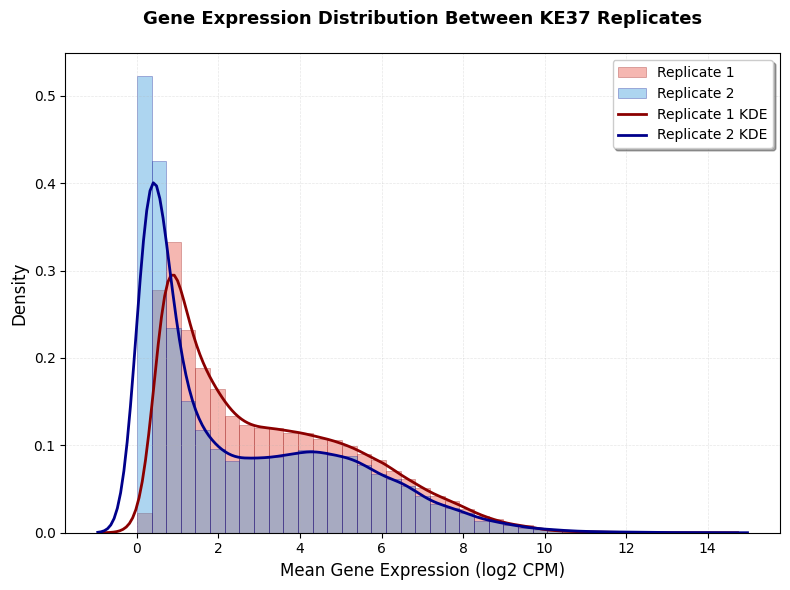

In [15]:
# Advanced histogram with KDE overlay
fig, ax = plt.subplots(figsize=(8, 6))

# Filter out very low expression for better visualization
expressed_mask = (rep1_expr > 0.5) | (rep2_expr > 0.5)
rep1_expressed = rep1_expr[expressed_mask]
rep2_expressed = rep2_expr[expressed_mask]

bins = np.linspace(0, max(rep1_expressed.max(), rep2_expressed.max()), 40)

# Histograms with density
ax.hist(rep1_expressed, bins=bins, alpha=0.4, label='Replicate 1',
        color='#E74C3C', edgecolor='darkred', linewidth=0.5, density=True)
ax.hist(rep2_expressed, bins=bins, alpha=0.4, label='Replicate 2',
        color='#3498DB', edgecolor='darkblue', linewidth=0.5, density=True)

# Add KDE overlay using seaborn
sns.kdeplot(data=rep1_expressed, color='darkred', linewidth=2, 
            label='Replicate 1 KDE', ax=ax)
sns.kdeplot(data=rep2_expressed, color='darkblue', linewidth=2,
            label='Replicate 2 KDE', ax=ax)

ax.set_xlabel('Mean Gene Expression (log2 CPM)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Gene Expression Distribution Between KE37 Replicates\n', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import pearsonr, spearmanr
pearson_r, _ = pearsonr(rep1_expr, rep2_expr)
spearman_r, _ = spearmanr(rep1_expr, rep2_expr)

print(f"Pearson r = {pearson_r:.3f}")
print(f"Spearman r = {spearman_r:.3f}")

Pearson r = 0.955
Spearman r = 0.856


In [17]:
centriole_samples = sample_info[(sample_info['condition']=='with_centrioles') & (sample_info['cell_line']=='RPE-p53KO')].index
control_samples = sample_info[sample_info['condition']=='without_centrioles'].index
# use CPM values
centriole_counts = log_cpm[centriole_samples]
control_counts = log_cpm[control_samples]

# calculate mean expression and fold change
mean_centrioles = centriole_counts.mean(axis=1)
control_expr = control_counts.mean(axis=1)
fold_change = mean_centrioles - control_expr
mean_expr = (mean_centrioles + control_expr) / 2

In [18]:
from scipy.stats import gaussian_kde
# calculate the point density
xy = np.vstack([mean_expr, fold_change])
z = gaussian_kde(xy)(xy)

In [ ]:
# save the list of significant genes
significant_genes = fold_change[(fold_change >= 1) & (mean_expr >= 3)]
significant_genes.to_csv('/home/jiguo/SeqAna_Pipe/significant_genes_RPE-p53KO_vs_Control.txt', sep='\t', header=['Log2_Fold_Change'])

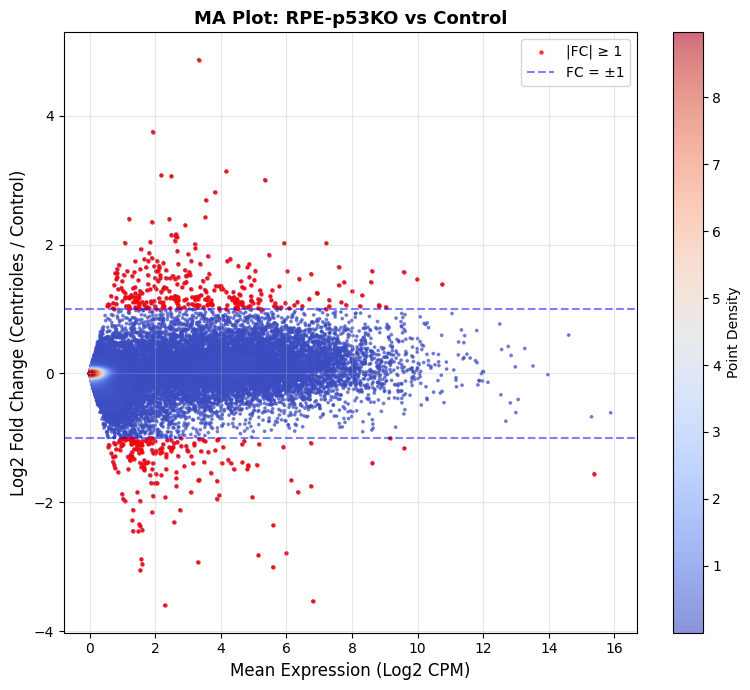

In [22]:

fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))

# === MA Plot with Density ===
idx = z.argsort()
x, y, z_sorted = mean_expr.iloc[idx], fold_change.iloc[idx], z[idx]

scatter = ax1.scatter(x, y, c=z_sorted, s=3, cmap='coolwarm', alpha=0.6)
# highlight the significant points
significant = fold_change.abs() >= 1
ax1.scatter(mean_expr[significant], fold_change[significant], 
            color='red', s=5, alpha=0.7, label='|FC| ≥ 1')
plt.colorbar(scatter, ax=ax1, label='Point Density')

ax1.axhline(1, color='blue', linestyle='--', linewidth=1.5, alpha=0.5, label='FC = ±1')
ax1.axhline(-1, color='blue', linestyle='--', linewidth=1.5, alpha=0.5)

ax1.set_xlabel('Mean Expression (Log2 CPM)', fontsize=12)
ax1.set_ylabel('Log2 Fold Change (Centrioles / Control)', fontsize=12)
ax1.set_title('MA Plot: RPE-p53KO vs Control', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()